In [1]:
import os
import csv
import platform
import pandas as pd
import networkx as nx
from graph_partitioning import GraphPartitioning, utils

run_metrics = True
#dumpAssignments = True

cols = ["WASTE", "CUT RATIO", "EDGES CUT", "TOTAL COMM VOLUME", "Qds", "CONDUCTANCE", "MAXPERM", "NMI", "FSCORE", "FSCORE RELABEL IMPROVEMENT"]
pwd = %pwd

config = {
    #"DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "rand_edge_weights", "network_1.txt"),
    "DATA_FILENAME": os.path.join(pwd, "data", "predition_model_tests", "network", "network_1.txt"),
    "OUTPUT_DIRECTORY": os.path.join(pwd, "output"),

    # Set which algorithm is run for the PREDICTION MODEL.
    # Either: 'FENNEL' or 'SCOTCH'
    "PREDICTION_MODEL_ALGORITHM": "SCOTCH",

    # Alternativly, read input file for prediction model.
    # Set to empty to generate prediction model using algorithm value above.
    "PREDICTION_MODEL": "",

    
    "PARTITIONER_ALGORITHM": "SCOTCH",

    # File containing simulated arrivals. This is used in simulating nodes
    # arriving at the shelter. Nodes represented by line number; value of
    # 1 represents a node as arrived; value of 0 represents the node as not
    # arrived or needing a shelter.
    "SIMULATED_ARRIVAL_FILE": os.path.join(pwd,
                                           "data",
                                           "predition_model_tests",
                                           "dataset_1_shift_rotate",
                                           "simulated_arrival_list",
                                           "percentage_of_prediction_correct_90",
                                           "arrival_90_1.txt"
                                          ),
    
    # File containing the prediction of a node arriving. This is different to the
    # simulated arrivals, the values in this file are known before the disaster.
    "PREDICTION_LIST_FILE": os.path.join(pwd,
                                         "data",
                                         "predition_model_tests",
                                         "dataset_1_shift_rotate",
                                         "prediction_list",
                                         "prediction_1.txt"
                                        ),

    # File containing the geographic location of each node, in "x,y" format.
    "POPULATION_LOCATION_FILE": os.path.join(pwd,
                                             "data",
                                             "predition_model_tests",
                                             "coordinates",
                                             "coordinates_1.txt"
                                            ),

    # Number of shelters
    "num_partitions": 4,

    # The number of iterations when making prediction model
    "num_iterations": 1,

    # Percentage of prediction model to use before discarding
    # When set to 0, prediction model is discarded, useful for one-shot
    "prediction_model_cut_off": 0.25,

    # Alpha value used in one-shot (when restream_batches set to 1)
    "one_shot_alpha": 0.5,

    # Number of arrivals to batch before recalculating alpha and restreaming.
    # When set to 1, one-shot is used with alpha value from above
    "restream_batches": 40,

    # When the batch size is reached: if set to True, each node is assigned
    # individually as first in first out. If set to False, the entire batch
    # is processed and empty before working on the next batch.
    "sliding_window": False,

    # Create virtual nodes based on prediction model
    "use_virtual_nodes": False,

    # Virtual nodes: edge weight
    "virtual_edge_weight": 1.0,

    # Loneliness score parameter. Used when scoring a partition by how many
    # lonely nodes exist.
    "loneliness_score_param": 1.2,

    ####
    # GRAPH MODIFICATION FUNCTIONS

    # Also enables the edge calculation function.
    "graph_modification_functions": True,

    # If set, the node weight is set to 100 if the node arrives at the shelter,
    # otherwise the node is removed from the graph.
    "alter_arrived_node_weight_to_100": False,

    # Uses generalized additive models from R to generate prediction of nodes not
    # arrived. This sets the node weight on unarrived nodes the the prediction
    # given by a GAM.
    # Needs POPULATION_LOCATION_FILE to be set.
    "alter_node_weight_to_gam_prediction": False,
    
    # Enables edge expansion when graph_modification_functions is set to true
    "edge_expansion_enabled": True,

    # The value of 'k' used in the GAM will be the number of nodes arrived until
    # it reaches this max value.
    "gam_k_value": 100,

    # Alter the edge weight for nodes that haven't arrived. This is a way to
    # de-emphasise the prediction model for the unknown nodes.
    "prediction_model_emphasis": 1.0,
    
    # This applies the prediction_list_file node weights onto the nodes in the graph
    # when the prediction model is being computed and then removes the weights
    # for the cutoff and batch arrival modes
    "apply_prediction_model_weights": True,
    
    # Path to the scotch shared library
    "SCOTCH_LIB_PATH": os.path.join(pwd, "libs/scotch/macOS/libscotch.dylib")
    if 'Darwin' in platform.system()
    else "/usr/local/lib/libscotch.so",
    
    # Path to the PaToH shared library
    "PATOH_LIB_PATH": os.path.join(pwd, "libs/patoh/lib/macOS/libpatoh.dylib")
    if 'Darwin' in platform.system()
    else os.path.join(pwd, "libs/patoh/lib/linux/libpatoh.so"),
    
    "PATOH_ITERATIONS": 5,

    # Expansion modes: 'avg_node_weight', 'total_node_weight', 'smallest_node_weight'
    # 'largest_node_weight'
    # add '_squared' or '_sqrt' at the end of any of the above for ^2 or sqrt(weight)
    # i.e. 'avg_node_weight_squared
    "PATOH_HYPEREDGE_EXPANSION_MODE": 'no_expansion',
    
    # Whether nodes should be reordered using a centrality metric for optimal node assignments in batch mode
    # This is specific to FENNEL and at the moment Leverage Centrality is used to compute new noder orders
    "FENNEL_NODE_REORDERING_ENABLED": False,
    
    # Whether the Friend of a Friend scoring system is active during FENNEL partitioning.
    # FOAF employs information about a node's friends to determine the best partition when
    # this node arrives at a shelter and no shelter has friends already arrived
    "FENNEL_FRIEND_OF_A_FRIEND_ENABLED": True,


    # Alters how much information to print. Keep it at 1 for this notebook.
    # 0 - will print nothing, useful for batch operations.
    # 1 - prints basic information on assignments and operations.
    # 2 - prints more information as it batches arrivals.
    "verbose": 1
}

gp = GraphPartitioning(config)

# Optional: shuffle the order of nodes arriving
# Arrival order should not be shuffled if using GAM to alter node weights
#random.shuffle(gp.arrival_order)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
gp.load_network()

Graph loaded...
Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 2938
Average degree:   5.8760
Graph is undirected


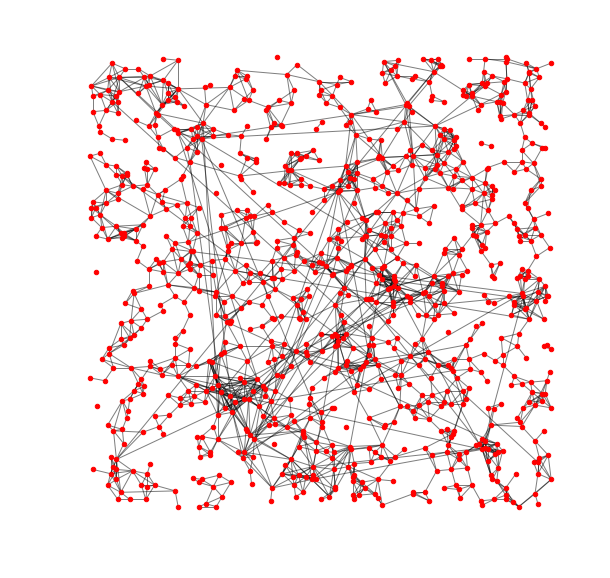

In [3]:
pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')

nx.draw_networkx_nodes(gp.G, pos, node_size=20, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

In [4]:
gp.init_partitioner()

SCOTCH partitioner loaded for generating PREDICTION MODEL.
SCOTCH partitioner loaded for making shelter assignments.


# Prediction Model

In [5]:
m = gp.prediction_model()

PREDICTION MODEL
----------------


Assignments:
[ 3  3  3  3  1  2  3  3  1  2  3  3  0  3  3  3  1  3  3  3  3  3  3  3  0  1  3  3  0  3  3  1  3  1  3  1  3  3  0  2  2  0  3  3  0  0  3  3  3  3  1  3  1  0  3  3  1  2  1  1  1  2  3  3  3  1  3  3  3  3  2  3  1  3  3  3  1  1  3  3  3  2  3  0  3  1  1  2  1  3  3  3  3  0  3  3  3  2  1  3  3  3  1  3  1  0  1  1  3  0  3  3  3  2  3  1  3  1  3  3  3  0  3  1  0  3  3  3  0  0  3  1  3  0  2  1  3  3  3  1  2  3  1  3  3  3  3  1  0  3  3  1  1  3  3  3  3  0  1  3  2  0  0  3  0  3  3  3  1  3  2  1  3  3  3  3  0  3  3  1  2  3  1  0  1  3  1  3  1  3  3  0  3  3  3  3  3  0  2  3  3  3  1  3  1  3  3  3  1  3  3  3  3  1  2  3  1  3  3  3  3  3  3  2  1  0  2  1  3  1  3  3  3  1  0  3  0  3  3  1  3  3  2  3  1  1  3  3  3  0  3  3  3  3  3  3  0  3  3  3  3  3  3  3  3  3  3  3  1  3  3  2  3  0  0  3  1  3  3  1  0  3  2  1  3  3  3  3  3  2  3  3  2  3  3  2  3  3  3  3  3  3  2  3  3  1  1  3  3  3  3  3  0  1  3  3  3

   WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME       Qds  CONDUCTANCE  \
1  0.075   0.088836        261                274  0.337278     0.262567   

    MAXPERM  NMI  FSCORE  FSCORE RELABEL IMPROVEMENT  
1  0.403014  1.0     1.0                         0.0  


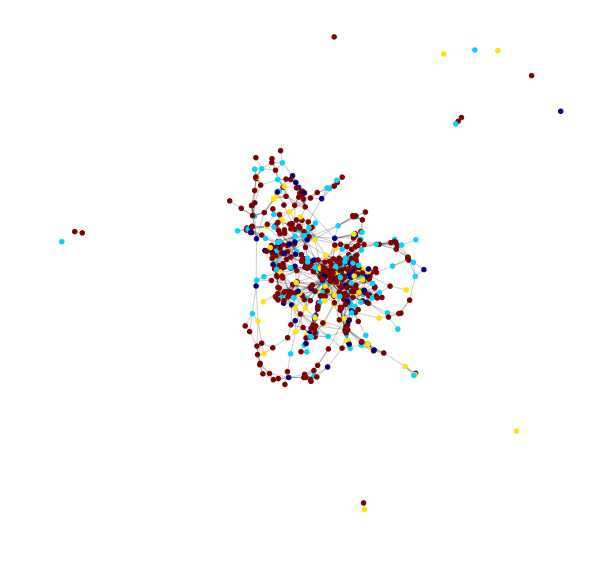

In [6]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

pos = nx.spring_layout(gp.G)
plt.figure(figsize=(10, 10))
plt.axis('off')
colours = {0: 'red', 1: 'blue', 2: 'yellow', 3: 'green'}

colour = []
#for n in gp.G.nodes_iter():
#    colour += [colours[gp.assignments[n]]]

nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=gp.assignments, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.2)
plt.show(gp.G)

#if dumpAssignments:
#    utils.write_assignment_file(gp.metrics_run_folder, gp.metrics_run_file_prefix_prediction + '-prediction-assignments.txt', gp.assignments)

# Assign Cut Off

In [7]:
m = gp.assign_cut_off()

Assign first 69 arrivals using prediction model, then discard


Assignments:
[-1 -1 -1 -1  1  2 -1 -1 -1 -1 -1 -1  0  3 -1 -1 -1  3  3 -1 -1 -1 -1 -1  0  1 -1 -1 -1  3 -1  1 -1  1 -1 -1 -1 -1  0 -1  2  0  3 -1 -1 -1 -1  3 -1 -1  1 -1 -1  0 -1  3  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  3  1  1 -1 -1 -1 -1 -1  0 -1  1  1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  2  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1  3 -1 -1  1 -1  1 -1 -1 -1  0  3  1 -1 -1 -1 -1  0 -1 -1  1 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1  3  3 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  3  0 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1  0 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  3 -1 -1 -1  0 -1 -1 -1  3 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3 -1  2 -1  0 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  3  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -

In [8]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols)
print(df)

#if dumpAssignments:
#    utils.write_assignment_file(gp.metrics_run_folder, gp.metrics_run_file_prefix_prediction + '-cutoff-assignments.txt', gp.assignments)

      WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME       Qds  CONDUCTANCE  \
1  0.391304   0.073171          3                  6  0.413314          0.0   

    MAXPERM  NMI  FSCORE  FSCORE RELABEL IMPROVEMENT  
1 -0.360628  1.0     1.0                         0.0  


# Run Simulation

In [9]:
m = gp.batch_arrival()

Assigning in batches of 40
--------------------------------


Assignments:
[-1 -1 -1 -1  1  2 -1 -1 -1 -1 -1 -1  0  3 -1 -1 -1  3  3 -1 -1 -1 -1 -1  0  1 -1 -1 -1  3 -1  1 -1  1 -1 -1 -1 -1  0 -1  2  0  3 -1 -1 -1 -1  3 -1 -1  1 -1 -1  0 -1  3  1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  3  1  1 -1 -1 -1 -1 -1  0 -1  1  1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1  2  1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  0 -1 -1  3 -1 -1  1 -1  1 -1 -1 -1  0  3  1 -1 -1 -1 -1  0 -1 -1  1 -1  0 -1  1 -1 -1 -1 -1 -1 -1 -1  3  3 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  3  0 -1 -1 -1 -1  0 -1  0 -1 -1 -1 -1 -1  2 -1 -1 -1 -1 -1  0 -1 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  3 -1 -1 -1  0 -1 -1 -1  3 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3  3 -1  2 -1  0 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  3  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1  2  3 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  0  2 -1  2  2 -1 -1  2 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1 -1  0  2 -1 -1 -1 -1 -1 -1 -1  2 -1 -1  0 -1 

      WASTE  CUT RATIO  EDGES CUT  TOTAL COMM VOLUME       Qds  CONDUCTANCE  \
1  0.027523   0.339806       35.0               50.0  0.545329     0.002006   
2  0.020134   0.460227       81.0              112.0  0.567985     0.005077   
3  0.015873   0.548736      152.0              200.0  0.528243     0.007137   
4  0.013100   0.593052      239.0              300.0  0.557467     0.006004   
5  0.011152   0.647788      366.0              420.0  0.549159     0.007200   
6  0.003584   0.648918      390.0              438.0  0.543178     0.010065   

    MAXPERM       NMI    FSCORE  FSCORE RELABEL IMPROVEMENT  
1 -0.229888  0.474086  0.763907                         0.0  
2 -0.220715  0.241563  0.618936                         0.0  
3 -0.243656  0.152371  0.536848                         0.0  
4 -0.140066  0.109095  0.493897                         0.0  
5 -0.099783  0.077132  0.453820                         0.0  
6 -0.099082  0.068805  0.441413                         0.0  


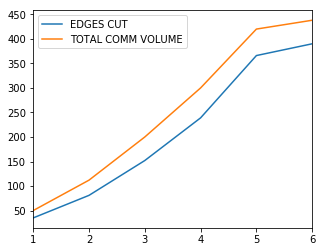

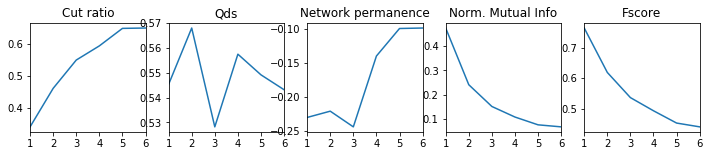

In [10]:
rows = list(range(1, len(m)+1))
df = pd.DataFrame(m, index=rows, columns=cols).astype(float)
print(df)

if len(df) > 1:
    t = 1
    xticks = rows[::t]
    df.plot(y=['EDGES CUT', 'TOTAL COMM VOLUME'], xticks=xticks, figsize=(5,4))

    fig, axs = plt.subplots(1,5)
    df.plot(y=['CUT RATIO'], title='Cut ratio', xticks=xticks, figsize=(12,2), legend=False, ax=axs[0])
    df.plot(y=['Qds'], title='Qds', xticks=xticks, figsize=(12,2), legend=False, ax=axs[1])
    #df.plot(y=['LONELINESS'], title='Loneliness', xticks=xticks, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['MAXPERM'], title='Network permanence', xticks=xticks, figsize=(12,2), legend=False, ax=axs[2])
    df.plot(y=['NMI'], title='Norm. Mutual Info', xticks=rows, figsize=(12,2), legend=False, ax=axs[3])
    df.plot(y=['FSCORE'], title='Fscore', xticks=rows, figsize=(12,2), legend=False, ax=axs[4])



else:
    print("\n\nNot enough data points to plot charts. There is only one row.")
    
#if dumpAssignments:
#    utils.write_assignment_file(gp.metrics_run_folder, gp.metrics_run_file_prefix_partitioner + '-batch-assignments.txt', gp.assignments)

# Network Visual

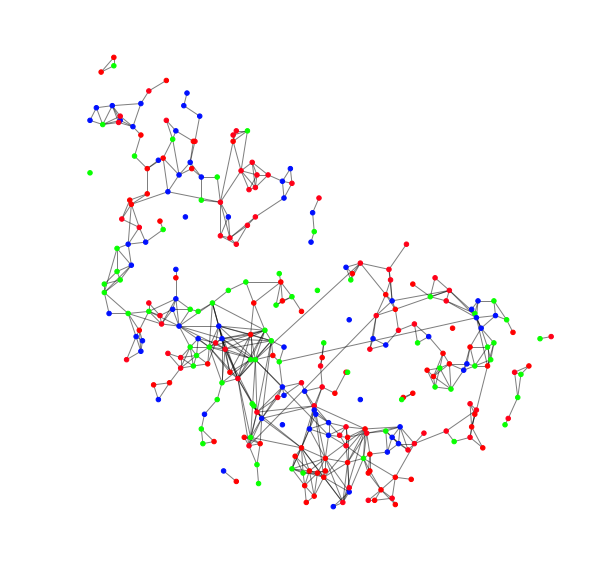

In [11]:
part = dict(zip(gp.G.nodes(), gp.assignments))
values = [part.get(node) for node in gp.G.nodes()]

pos_spring = nx.spring_layout(gp.G, k=0.5, iterations=20)

pos = {}
with open(gp.POPULATION_LOCATION_FILE, 'r') as csvfile: 
    reader = csv.reader(csvfile, delimiter=',')
    for node, row in enumerate(reader):
        pos[node] = np.array(row).astype(np.float)

# create colours
cmap = utils.get_cmap(gp.num_partitions)
colours = np.zeros((gp.G.number_of_nodes(), 4), dtype=np.float)
for i,n in enumerate(gp.G.nodes_iter()):
    if gp.assignments[n] == -1:
        col = [(1.0, 1.0, 1.0, 1.0)]
    else:
        col = [cmap(gp.assignments[n])]
    colours[i] = np.array(col, dtype=np.float)

plt.figure(figsize=(10, 10))
plt.axis('off')
nx.draw_networkx_nodes(gp.G, pos, node_size=20, node_color=colours, cmap=plt.cm.jet, with_labels=False)
nx.draw_networkx_edges(gp.G, pos, alpha=0.5)
plt.show(gp.G)

#nx.draw_networkx_nodes(gp.G, pos_spring, node_size=20, node_color=colour, cmap=plt.cm.jet, with_labels=False)
#nx.draw_networkx_edges(gp.G, pos_spring, alpha=0.5)
#plt.show(gp.G)

# Metrics

In [12]:
if run_metrics:
    gp.get_metrics()

Complete graph with 1000 nodes

Config
-------

file: 105316
num_partitions: 4
num_iterations: 1
prediction_model_cut_off: 0.25
restream_batches: 40
use_virtual_nodes: False
virtual_edge_weight: 1.0
edges_cut: 390

Metrics
-------

waste: 0.0010000000000000009
cut_ratio: 0.64891846921797
total_communication_volume: 438
network_permanence: -0.620997
Q: 0.7566877583395395
NQ: -1.2861829341172437
Qds: 0.11148905647807089
intraEdges: 22.854166666666668
interEdges: 4.375
intraDensity: 0.0965502826546585
modularity degree: 12.627168445589497
conductance: 0.6121912292623768
expansion: 1.0427022989027315
contraction: 1.5688343174689605
fitness: 0.36451762906026913
QovL: 0.9082322007339501

Partition 0 with 70 nodes
-----------------------------


Metrics
file: 105316
partition: 0
population: 70
Q: -0.031658739595719375
NQ: -8.399063733084295
Qds: -0.9999999999999996
intraEdges: 0.0
interEdges: 2.4166666666666665
intraDensity: 0.0
modularity degree: -116.0
conductance: 1.0
expansion: 2.41666666